## Pipiline NLP

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files

import warnings
warnings.filterwarnings('ignore')

In [3]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/txt_sentoken.zip

--2024-05-21 19:39:00--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/txt_sentoken.zip
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.148.154, 52.95.142.106, 52.95.149.190, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.148.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2781673 (2.7M) [application/octet-stream]
Saving to: ‘txt_sentoken.zip’

txt_sentoken.zip    100%[===================>]   2.65M  4.89MB/s    in 0.5s    

2024-05-21 19:39:01 (4.89 MB/s) - ‘txt_sentoken.zip’ saved [2781673/2781673]



In [5]:
!unzip txt_sentoken.zip

Archive:  txt_sentoken.zip
   creating: txt_sentoken/
   creating: txt_sentoken/neg/
  inflating: txt_sentoken/neg/cv000_29416.txt  
  inflating: txt_sentoken/neg/cv001_19502.txt  
  inflating: txt_sentoken/neg/cv002_17424.txt  
  inflating: txt_sentoken/neg/cv003_12683.txt  
  inflating: txt_sentoken/neg/cv004_12641.txt  
  inflating: txt_sentoken/neg/cv005_29357.txt  
  inflating: txt_sentoken/neg/cv006_17022.txt  
  inflating: txt_sentoken/neg/cv007_4992.txt  
  inflating: txt_sentoken/neg/cv008_29326.txt  
  inflating: txt_sentoken/neg/cv009_29417.txt  
  inflating: txt_sentoken/neg/cv010_29063.txt  
  inflating: txt_sentoken/neg/cv011_13044.txt  
  inflating: txt_sentoken/neg/cv012_29411.txt  
  inflating: txt_sentoken/neg/cv013_10494.txt  
  inflating: txt_sentoken/neg/cv014_15600.txt  
  inflating: txt_sentoken/neg/cv015_29356.txt  
  inflating: txt_sentoken/neg/cv016_4348.txt  
  inflating: txt_sentoken/neg/cv017_23487.txt  
  inflating: txt_sentoken/neg/cv018_21672.txt  
  inf

In [26]:
movie_data = load_files(r"txt_sentoken")
X_, y = movie_data.data, movie_data.target

In [27]:
df = pd.DataFrame({'text':X_})
df['label'] = y
df

,text,label
0,"b'lisa cholodenko\'s "" high art , "" is an inte...",1
1,"b'wolfgang petersen\'s latest , the perfect st...",0
2,b'i won\x12t even pretend that i have seen the...,0
3,b'there are some works of art that are almost ...,1
4,"b'albert brooks saves the day , just in the ni...",1
...,...,...
1408,"b'hav plenty , as we are told in the beginning...",0
1409,b'brian de palma\'s snake eyes stars nicolas c...,0
1410,b'contact ( pg ) there\'s a moment late in rob...,1
1411,"b""this is a film that i was inclined to like a...",0


In [28]:
## problemi di bytecode
def utfdecode(item):
    cleaned_item = item.decode('utf-8')
    return cleaned_item

df['text'] = df['text'].apply(utfdecode)
df

,text,label
0,"lisa cholodenko's "" high art , "" is an intelli...",1
1,"wolfgang petersen's latest , the perfect storm...",0
2,i wont even pretend that i have seen the othe...,0
3,there are some works of art that are almost im...,1
4,"albert brooks saves the day , just in the nick...",1
...,...,...
1408,"hav plenty , as we are told in the beginning a...",0
1409,brian de palma's snake eyes stars nicolas cage...,0
1410,contact ( pg ) there's a moment late in robert...,1
1411,this is a film that i was inclined to like at ...,0


In [42]:
## 1 Define Features and Target

X = df['text']
y = df['label']


In [43]:
import re

words_to_remove = ['gargamella', 'doggy', 'word3']
words_pattern = r'\b(?:' + '|'.join(map(re.escape, words_to_remove)) + r')\b'

patterns = {
            r"[a-zA-Z]+n\'t": 'not',
            r'\s+': ' ',             # Substitute multiple spaces with a single space
            r'\d+': '',              # Remove digits
            r'[^\w\s]': '',          # Remove punctuation and symbols
            r'\b\w{1,2}\b': '',      # Remove all tokens less than 2 characters
            r'(http|www)[^\s]+': '', # Remove websites
            words_pattern: ''        # Remove specific words
            }

def clean_column(df, column, patterns):
    df[column] = df[column].str.lower() # Apply lowercase transformation
    for pattern, replacement in patterns.items():
        df[column] = df[column].str.replace(pattern, replacement, regex=True)
    return df

In [62]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, patterns):
        self.patterns = patterns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=['text'])
        df = clean_column(df, 'text', self.patterns)
        return df['text'].values

## PUT REGEX inside Pipeline

In [71]:
text_cleaner = TextCleaner(patterns)
bow = CountVectorizer(max_features=15000,stop_words="english")
tfidf = TfidfTransformer()
clf = MultinomialNB(alpha=0.1)

pipe = Pipeline([
                ('text cleaner', text_cleaner),  ## Regex and clean
                ('bow', bow),                    ## BoW
                ('tfidf', tfidf),                ## TF-IDF
                ('classifier', clf),             ## Classifier
                ])

In [72]:
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(pipe, X, y, cv=5)
print(cross_val_scores)

# Calcola la media e la deviazione standard dei punteggi
mean_score = np.mean(cross_val_scores)
std_score = np.std(cross_val_scores)

print(f"Mean cross-validation score:{mean_score:.2f}")
print(f"Standard deviation of cross-validation scores:{std_score:.2f}")

[0.76678445 0.80565371 0.76325088 0.77659574 0.75531915]
Mean cross-validation score:0.77
Standard deviation of cross-validation scores:0.02


In [73]:
pipe.fit(X, y)

Pipeline(steps=[('text cleaner',
                 TextCleaner(patterns={'(http|www)[^\\s]+': '', '[^\\w\\s]': '',
                                       "[a-zA-Z]+n\\'t": 'not',
                                       '\\b(?:gargamella|doggy|word3)\\b': '',
                                       '\\b\\w{1,2}\\b': '', '\\d+': '',
                                       '\\s+': ' '})),
                ('bow',
                 CountVectorizer(max_features=15000, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB(alpha=0.1))])

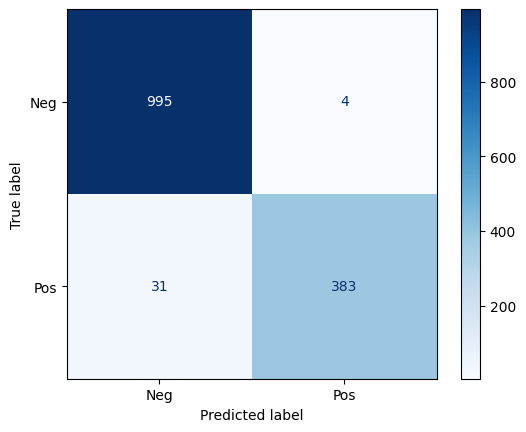

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = ['Neg','Pos']
ConfusionMatrixDisplay.from_estimator(pipe,
                                        X,
                                        y,
                                        cmap='Blues',
                                        display_labels=labels,
                                        );

In [75]:
y_pred_tot = pipe.predict(X)

In [76]:
from sklearn.metrics import classification_report

labels = ['Neg','Pos']
classification_report(y,y_pred_tot )
classification_report_result = classification_report(y, y_pred_tot,target_names=labels)
print(classification_report_result)

              precision    recall  f1-score   support

         Neg       0.97      1.00      0.98       999
         Pos       0.99      0.93      0.96       414

    accuracy                           0.98      1413
   macro avg       0.98      0.96      0.97      1413
weighted avg       0.98      0.98      0.97      1413



In [77]:
aa = pd.DataFrame({'text':["Hello, gargamella doggy don't 123 @!£$%' \''s    \n hi"]})

pipe.predict(aa)

array([0])

In [78]:
import joblib

joblib.dump(pipe,'sent_pipe.pkl')

['sent_pipe.pkl']

In [79]:
model_pipe = joblib.load('sent_pipe.pkl')
print('Model loaded successfully')

Model loaded successfully


In [80]:
model_pipe

Pipeline(steps=[('text cleaner',
                 TextCleaner(patterns={'(http|www)[^\\s]+': '', '[^\\w\\s]': '',
                                       "[a-zA-Z]+n\\'t": 'not',
                                       '\\b(?:gargamella|doggy|word3)\\b': '',
                                       '\\b\\w{1,2}\\b': '', '\\d+': '',
                                       '\\s+': ' '})),
                ('bow',
                 CountVectorizer(max_features=15000, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB(alpha=0.1))])